<h1>Содержание<span class="tocSkip"></span></h1>
<li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
import warnings
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import os
warnings.filterwarnings('ignore')

# параметры обучения
TEST_SIZE = 0.1
RANDOM_STATE = 42

## Подготовка

In [2]:
def loading_info(pth):
    """
    Функция загрузки датасетов и 
    """
    if os.path.exists(pth):
        #загрузка данных из файла
        data = pd.read_csv(pth, parse_dates=[0])
        # отобразим загруженный датасеты
        display(data.head())
        # отобразим основную информацию о загруженном датасете
        display(data.info())
        display(data.describe())
        return data
    else:
        print(f"Не верный путь к файлу: {pth}")

In [3]:
# путь к файлам с датасетами
pth = '/datasets/taxi.csv'

taxi = loading_info(pth)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
taxi['datetime'] = taxi['datetime'].astype('datetime64')
taxi.set_index('datetime', inplace=True)

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Вывод** таким образом, были подключены все необходимые библиотеки, загружен датасет, поле с датой преобразовано в тип datetime64 и преобразовано в поле индексов датафрейма.

## Анализ

In [6]:
taxi.sort_index(inplace=True)

<AxesSubplot:xlabel='datetime'>

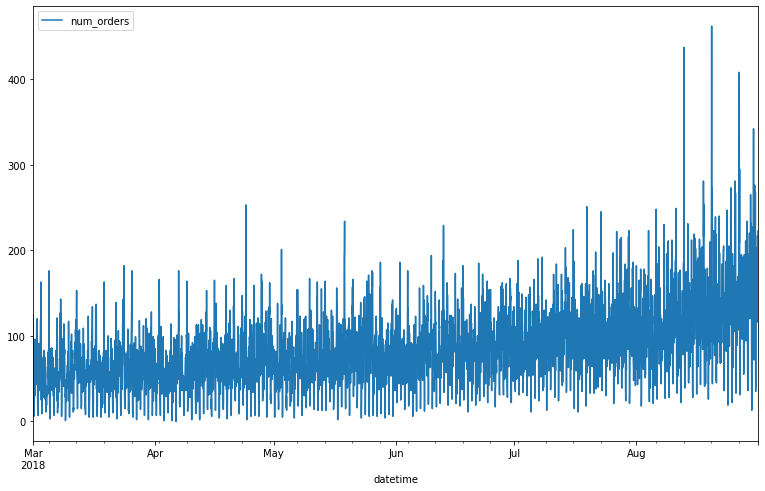

In [7]:
resrm_taxi = taxi.resample('1H').sum()
figsize = (13,8)
resrm_taxi.plot(figsize=figsize)

Попробуем построеть график для меньших периодов (1 месяц, 5 дней). Будем использовать данные за август месяц, там судя по графику увеличивается среднее и увеличивается разброс данных.

<AxesSubplot:xlabel='datetime'>

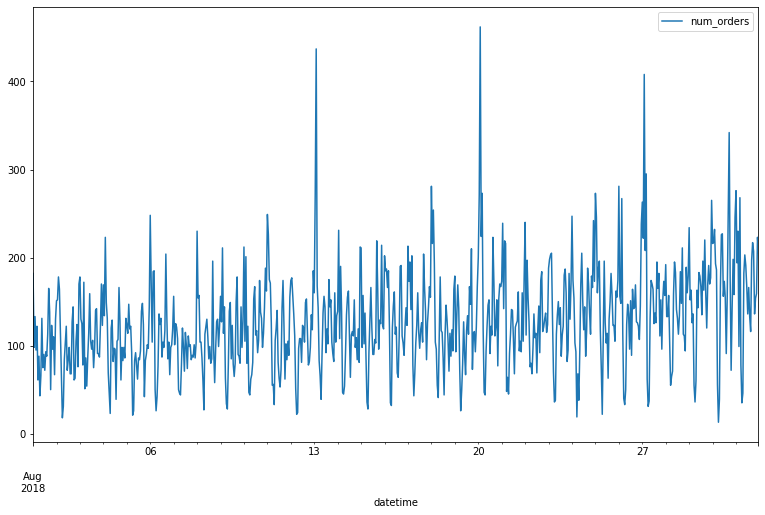

In [8]:
interval_less_month = taxi['2018-08-01':'2018-08-31']
interval_less_month = interval_less_month.resample('1H').sum()
figsize = (13, 8)
interval_less_month.plot(figsize=figsize)

<AxesSubplot:xlabel='datetime'>

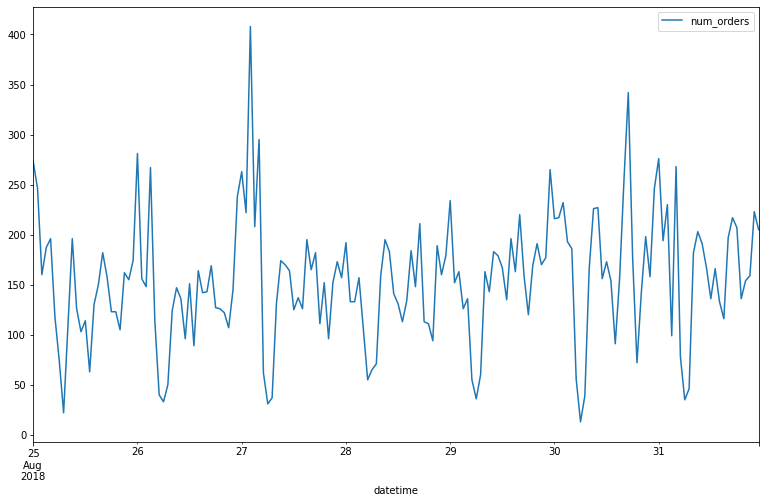

In [9]:
interval_less_day = taxi['2018-08-25':'2018-08-31']
interval_less_day = interval_less_day.resample('1H').sum()
figsize = (13,8)
interval_less_day.plot(figsize=figsize)

По данным графикам ничего не понятно. Отобразим сезонность и тренды для разных периодов.

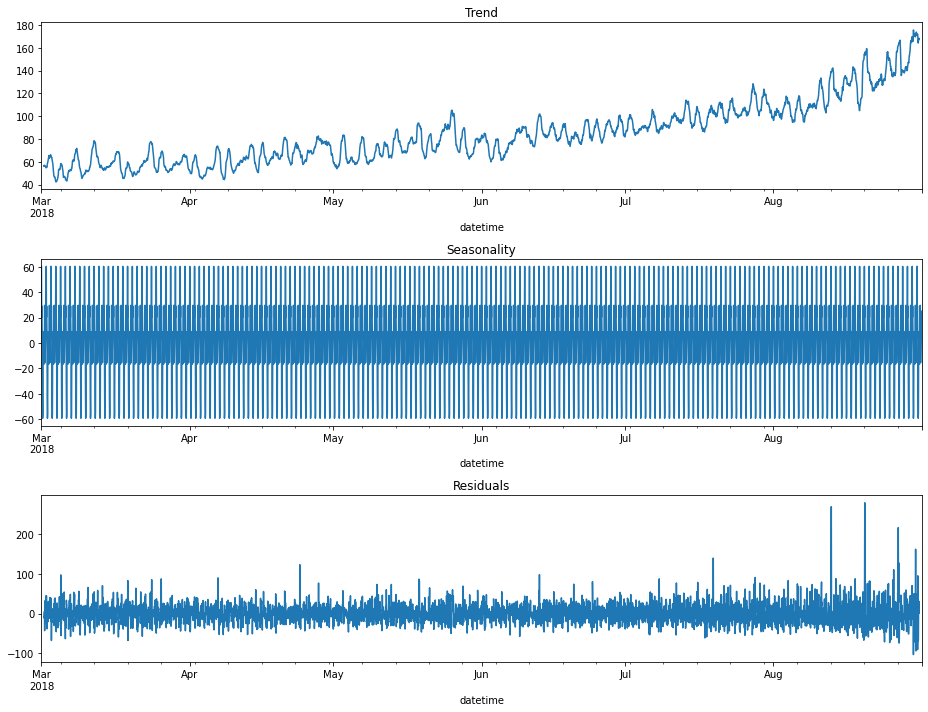

In [10]:
decomposed = seasonal_decompose(resrm_taxi)

plt.figure(figsize=(13, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

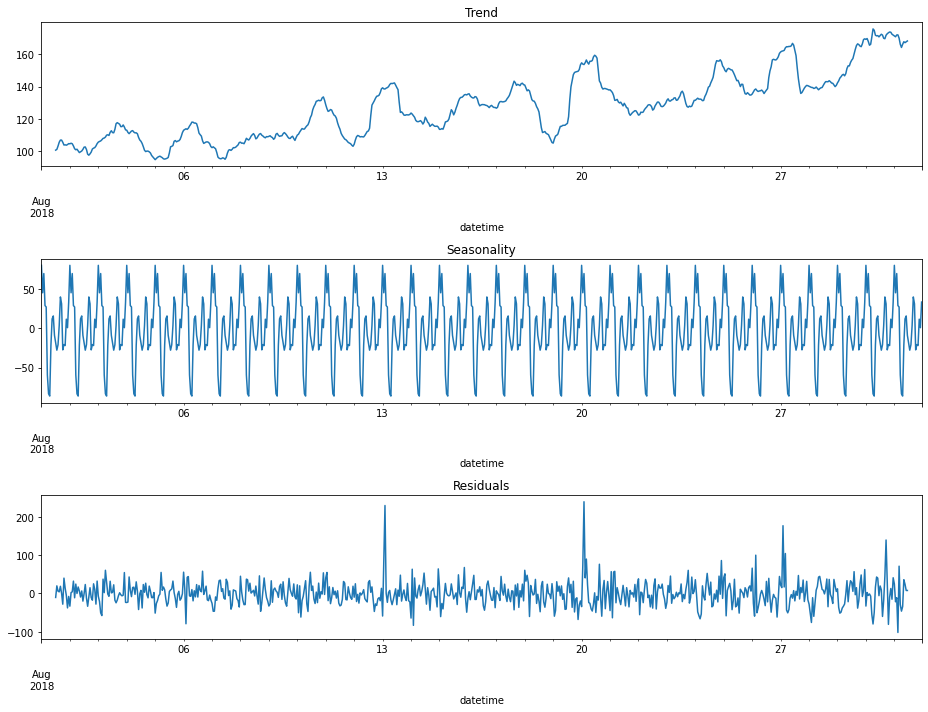

In [11]:
decomposed = seasonal_decompose(interval_less_month)

plt.figure(figsize=(13, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

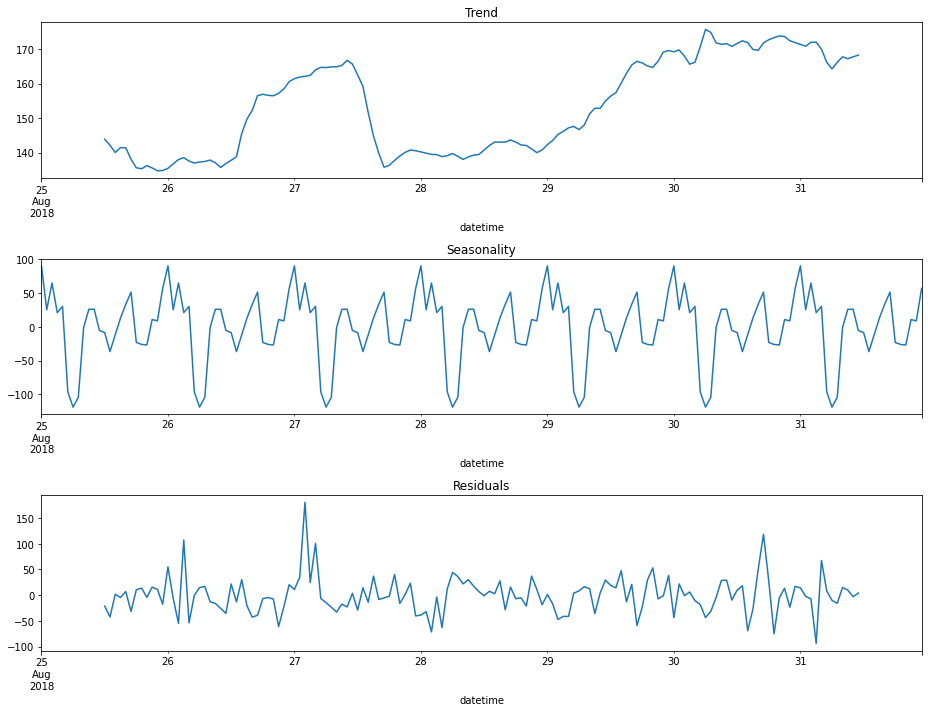

In [12]:
decomposed = seasonal_decompose(interval_less_day)

plt.figure(figsize=(13, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

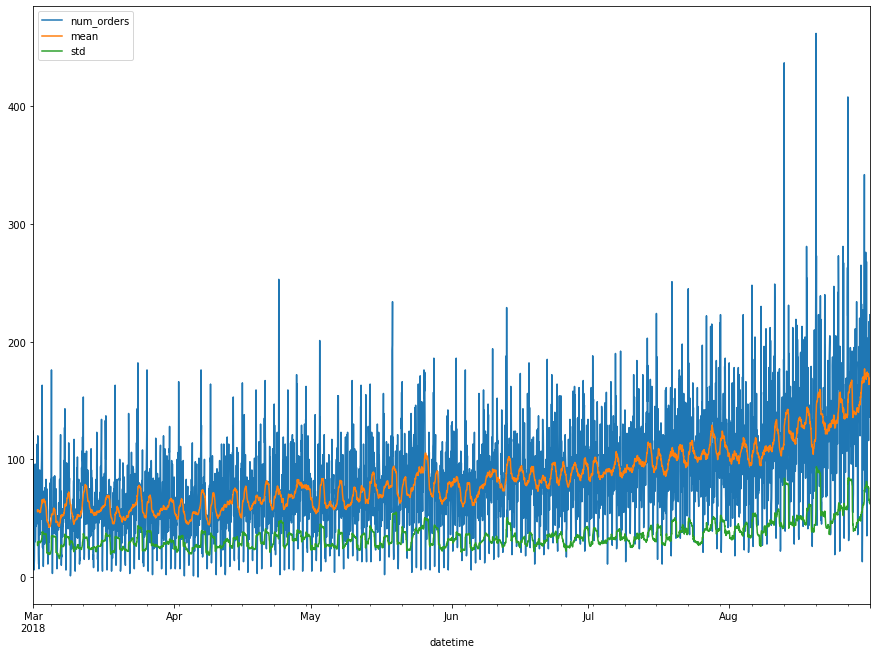

In [13]:
taxi_rolling = taxi.resample('1H').sum()
taxi_rolling['mean'] = taxi_rolling['num_orders'].rolling(24).mean()
taxi_rolling['std'] = taxi_rolling['num_orders'].rolling(24).std()
figsize = (15,11)
taxi_rolling.plot(figsize=figsize) 

<AxesSubplot:xlabel='datetime'>

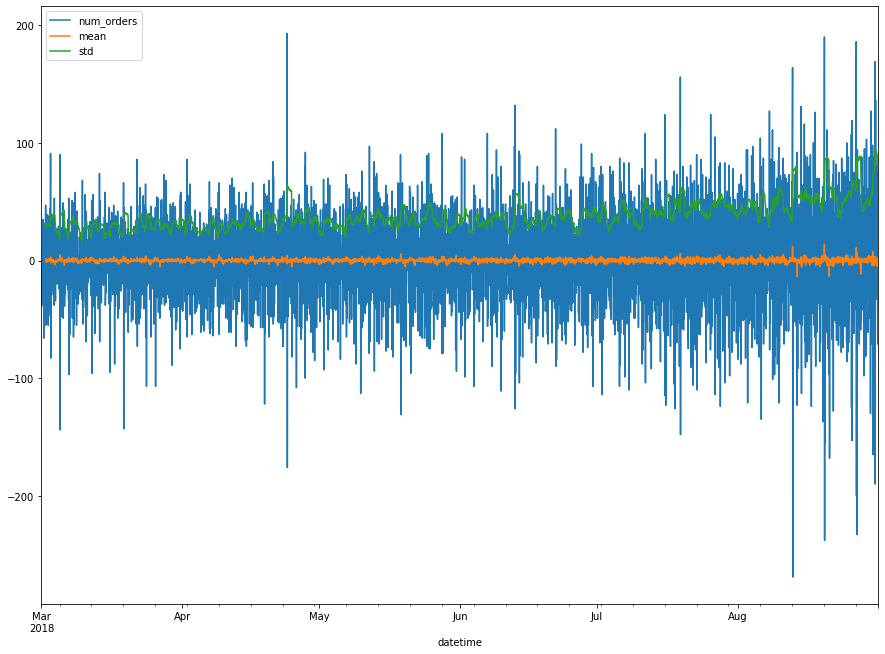

In [14]:
taxi_rolling = taxi.resample('1H').sum()
taxi_rolling = taxi_rolling - taxi_rolling.shift()
taxi_rolling['mean'] = taxi_rolling['num_orders'].rolling(24).mean()
taxi_rolling['std'] = taxi_rolling['num_orders'].rolling(24).std()
figsize = (15,11)
taxi_rolling.plot(figsize=figsize) 

**Вывод**
- тренд увеличивается, значит количество заказов и пользователей растёт,
- среднее также увеличивается,
- в течении дня заметно несколько скачков (утром, обед, вечер-ночь) с увелечением заказов, при этом ранним утром резко падает количество заказов,
- временной ряд не стационарный, так как увеличивается тренд, среднее и дисперсия.

## Обучение

Добавим новых признаков.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
make_features(resrm_taxi, 48, 24)

In [17]:
train, test = train_test_split(resrm_taxi, shuffle=False, test_size=TEST_SIZE)
train = train.dropna()

X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

In [18]:
pipe_final = Pipeline([
    ('models', LinearRegression())
])

In [19]:
param_grid = [

    {
        'models': [LinearRegression()]  
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 31, 5),
        'models__max_features': range(5, 21, 5)
    },
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE, silent=True)],
        'models__depth': [5, 10],
        'models__learning_rate': [0.05, 0.1],
        'models__iterations': [100, 200, 500]
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 16, 5),
        'models__num_leaves': range(5, 11, 5), 
        'models__learning_rate': [0.02]
    }
]

Используем дополнительный параметр для использования кросс-валидации на временных рядах.

In [23]:
tscv = TimeSeriesSplit(n_splits=2)

In [24]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv = tscv,
    scoring='neg_root_mean_squared_error',
    verbose=3
)

In [25]:
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 43 candidates, totalling 86 fits
[CV 1/2] END ......................models=LinearRegression(); total time=   0.0s
[CV 2/2] END ......................models=LinearRegression(); total time=   0.2s
[CV 1/2] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5; total time=   0.2s
[CV 2/2] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=5; total time=   0.0s
[CV 1/2] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10; total time=   0.0s
[CV 2/2] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=10; total time=   0.0s
[CV 1/2] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15; total time=   0.0s
[CV 2/2] END models=DecisionTreeRegressor(random_state=42), models__max_depth=5, models__max_features=15; total time=   0.0s
[CV 1/2] END models=DecisionT

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

[CV 1/2] END models=<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, models__depth=5, models__iterations=100, models__learning_rate=0.05; total time=   0.9s
[CV 2/2] END models=<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, models__depth=5, models__iterations=100, models__learning_rate=0.05; total time=   0.9s
[CV 1/2] END models=<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, models__depth=5, models__iterations=100, models__learning_rate=0.1; total time=   0.9s
[CV 2/2] END models=<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, models__depth=5, models__iterations=100, models__learning_rate=0.1; total time=   1.1s
[CV 1/2] END models=<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, models__depth=5, models__iterations=200, models__learning_rate=0.05; total time=   1.4s
[CV 2/2] END models=<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, models__depth=5, models__iterations=200, models__learning_rate=0.05; total time=  

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('models', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LinearRegression()]},
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 31, 5),
                          'models__max_features': range(5, 21, 5)},
                         {'models': [<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>],
                          'models__depth': [5, 10],
                          'models__iterations': [100, 200, 500],
                          'models__learning_rate': [0.05, 0.1]},
                         {'models': [LGBMRegressor(random_state=42)],
                          'models__learning_rate': [0.02],
                          'models__max_depth': range(5, 16, 5),
                          'models__num_leaves': range(5, 11, 5)}],
     

In [26]:
results = pd.DataFrame(grid_search.cv_results_)
pd.set_option('display.max_colwidth', None)

results['model_type'] = results['param_models'].apply(lambda x: x.__class__.__name__)

best_params_per_model = results.loc[results.groupby('model_type')['rank_test_score'].idxmin()]

display(best_params_per_model[['param_models', 'params', 'mean_test_score', 'mean_fit_time']])

,param_models,params,mean_test_score,mean_fit_time
30,<catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>,"{'models': <catboost.core.CatBoostRegressor object at 0x7ff511d78fa0>, 'models__depth': 5, 'models__iterations': 500, 'models__learning_rate': 0.1}",-26.060694,3.049768
4,DecisionTreeRegressor(random_state=42),"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 20}",-32.332656,0.016535
38,LGBMRegressor(random_state=42),"{'models': LGBMRegressor(random_state=42), 'models__learning_rate': 0.02, 'models__max_depth': 5, 'models__num_leaves': 10}",-28.966959,0.596337
0,LinearRegression(),{'models': LinearRegression()},-80.216246,0.085992


**Вывод** Таким образом, мы получили лучшие параметры для каждой модели, при этом лучшую точность мы получили на модели CatBoost. Будем использовать её на тестовой выборке.

## Тестирование

In [30]:
y_pred = grid_search.predict(X_test)
print(f'Метрика RMSE на тестовой выборке: {(mean_squared_error(y_test, y_pred))**0.5}')

Метрика RMSE на тестовой выборке: 39.9379032623285


Таким образом, мы получили значение RMSE 39.9, что меньше 48. Задча выполнена.

Построим графики для исходного временного ряда и для предсказаний.

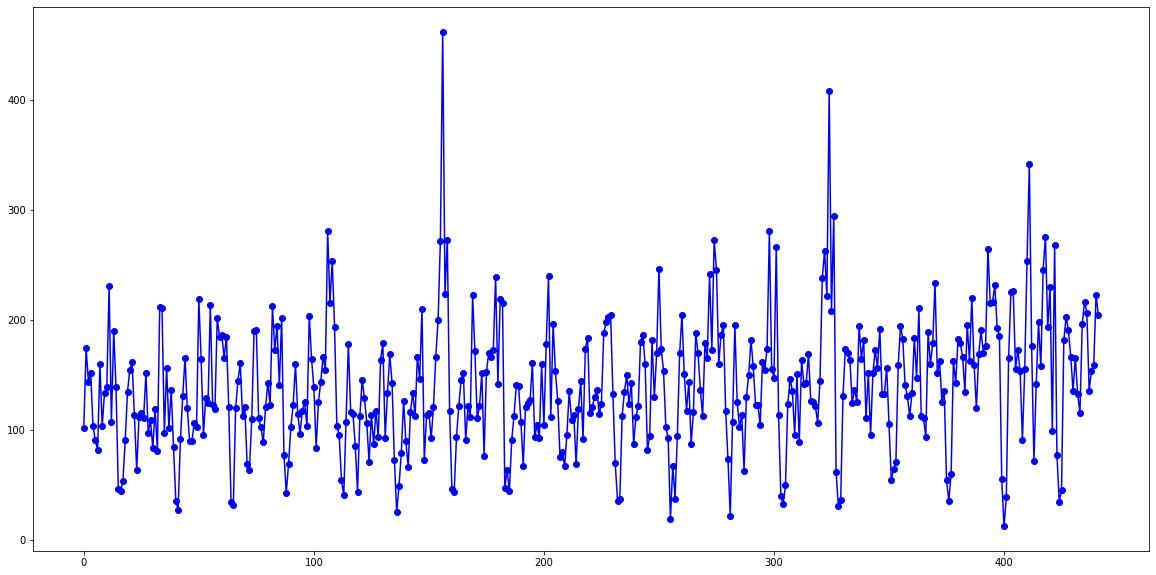

In [52]:
time = range(len(y_test))
plt.figure(figsize=(20, 10))
plt.plot(time, y_test, label='Actual', color='blue', linestyle='-', marker='o')

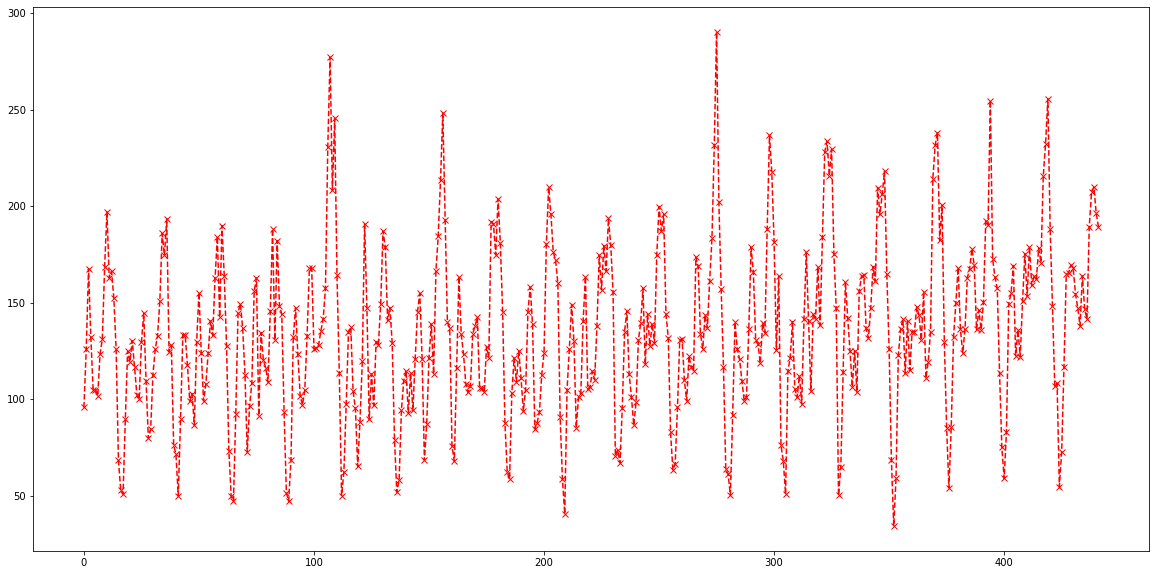

In [53]:
plt.figure(figsize=(20, 10))
plt.plot(time, y_pred, label='Predicted', color='red', linestyle='--', marker='x')
plt.show()

## Итоговый вывод

- данные загружены и приведены в рабочий вид
- построены графики ресемплаирования по часу для разных периодов времени,
- построены графики тренда и сезонности для разных периодов времени,
- посроены графики со скользящим стандартным отклонением и со скользящим средним,
- по всем показателям пришли к вывод, что временной ряд не стационарный,
- выбраны 4 модели: CatBoostRegressor, DecisionTreeRegressor, LGBMRegressor, LinearRegression для решения данной задачи,
- используя паплайн подобрали лучшие параметры моделий,
- выбрали модель с самой маленькой метриков на кросс-валидации и сделали предсказания на тестовых данных, высчитали метрику rmse.

В итоге лучше всего с поставленно задачей справилась модель CatBoostRegressor, она имеет самую высокую точность, хотя время обучения на кросс-валидации самое большое среди 4 моделей.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48